In [1]:
# importing needed packages
import logging
from graph_recommender_system import GraphRecommendationSystem, load_data
import pandas as pd
import time

In [2]:
# Logging settings
logging.basicConfig(filename='info.log', level=logging.INFO)
# Initialize and connect to database
db = GraphRecommendationSystem("bolt://localhost:7687", "neo4j", "")
# NB this will run for ~8 hours

In [3]:
total_time = time.time()
# Split the data in train and test data
(train, test) = db.get_file_paths("active1000", 0.7)
# Importing train data from files to database (only need to run once) 
# db.import_data("active1000", train)  # NB this will run for ~8 hours
#logging.info(f"Import data took: {((time.time() - total_time)/60.0)} minutes") 

In [4]:
# Creating dataframes of the data to be used in evaluating the results from the recommendations
df_test = load_data("active1000", test)
df_train = load_data("active1000", train)

988


,counts
count,988.000000
mean,363.741903
std,199.536766
min,11.000000
25%,250.000000
50%,330.000000
75%,427.250000
max,3618.000000


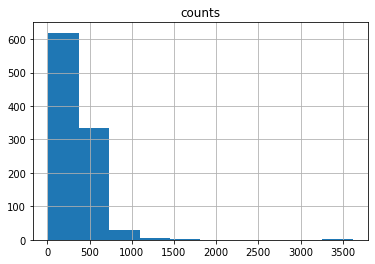

In [5]:
# Fetching users to be used in recommendations
df_test = df_test[df_test["url"] != "http://adressa.no"]
user_df = df_test.groupby(['userId']).size().reset_index(name='counts')
user_df = user_df.sort_values(["counts"], ascending=False)
user_df.hist()
users = user_df["userId"].tolist()
print(len(users))
user_df.describe()

# Evaluation basics  
[Source](https://bond-kirill-alexandrovich.medium.com/precision-and-recall-in-recommender-systems-and-some-metrics-stuff-ca2ad385c5f8)

TP = True positives  
TN = True negatives  
FP = False positives  
FN = False negatives  

Accuracy = (TP + TN) / (TP+TN+FP+FN)  
Precision = TP / (TP + FP)  
Recall = TP / (TP+FN)  

In [6]:
def precision(test_data_user, predictions):
    if(len(predictions) == 0):
        return 0
    true_positives = test_data_user[test_data_user["url"].isin(predictions["url"])]
    true_positive_false_positive = predictions
    return 100*(len(true_positives)/len(true_positive_false_positive)) # TP / (TP + FP)

def precision_per_user(df_predictions, df_test_data):
    test_data = df_test_data[["userId", "url"]]
    precisions = test_data.groupby('userId').apply(lambda user: precision(user, df_predictions[df_predictions["userId"] == user["userId"].iloc[0]]))
    return precisions

In [7]:
def recall(test_data_user, predictions):
    true_positives = test_data_user[test_data_user["url"].isin(predictions["url"])]
    true_positives_false_negatives = test_data_user
    return 100*(len(true_positives)/len(true_positives_false_negatives)) # TP / (TP + FN)

def recall_per_user(df_predictions, df_test_data):
    test_data = df_test_data[["userId", "url"]]
    recalls = test_data.groupby('userId').apply(lambda user: recall(user, df_predictions[df_predictions["userId"] == user["userId"].iloc[0]]))
    return recalls

In [8]:
def f1(test_data_user, predictions):
    r = recall(test_data_user, predictions)
    p = precision(test_data_user, predictions)
    rp = r+p
    if rp == 0:
        return 0
    return (2*p*r)/rp

def f1_per_user(df_predictions, df_test_data):
    test_data = df_test_data[["userId", "url"]]
    f1s = test_data.groupby('userId').apply(lambda user: f1(user, df_predictions[df_predictions["userId"] == user["userId"].iloc[0]]))
    return f1s

In [9]:
def click_through_rate(users, nr_of_recommendations, test_data_user, predictions):
    user_clicks = test_data_user[test_data_user["url"].isin(predictions["url"])]
    return 100 * len(user_clicks) / (len(users) * nr_of_recommendations)

# Prediction: Predict articles by nearest neighbor and popularity

In [10]:
# Predict all users on popularity (uncomment to run)
start_time = time.time()
#predictions_raw_df = db.predict_on_popularity(users, None) # NB: runs for ~1 hours
#predictions_raw_df.to_feather("predictions_popularity_all_users_v4.feather")
logging.info(f"Prediction took: {((time.time() - start_time)/60.0)} minutes, or hours: {((time.time() - start_time)/3600.0)}")


<AxesSubplot:>

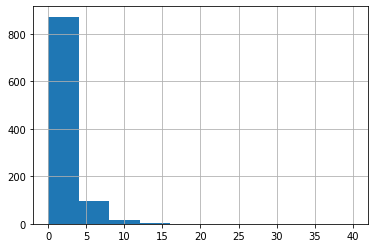

In [11]:
# Evaluating: 20 predictions per user, for all users, on popularity
predictions_popularity = pd.read_feather("predictions_popularity_all_users_v4.feather")
precision_popularity = precision_per_user(predictions_popularity, df_test)
precision_popularity.hist()

In [12]:
precision_popularity.mean()

0.7489878542510121

<AxesSubplot:>

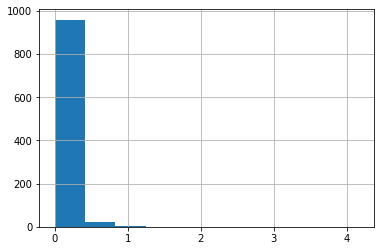

In [13]:
recall_popularity = recall_per_user(predictions_popularity, df_test)
recall_popularity.hist()

In [14]:
recall_popularity.mean()

0.04518091712083899

<AxesSubplot:>

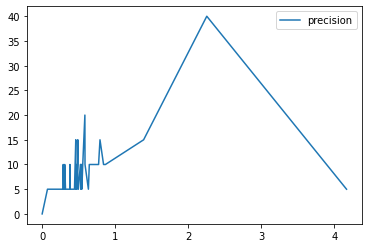

In [15]:
recall_precision_plot_popularity = pd.concat([precision_popularity, recall_popularity], keys=["precision", "recall"], axis=1)
recall_precision_plot_popularity = recall_precision_plot_popularity.sort_values(["recall"])
recall_precision_plot_popularity.plot.line(x="recall", y="precision", xlabel="")

<AxesSubplot:>

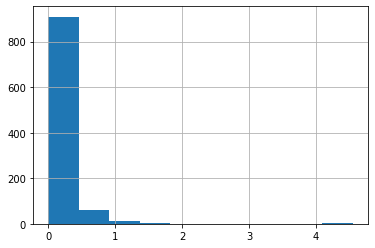

In [16]:
f1_popularity = f1_per_user(predictions_popularity, df_test)
f1_popularity.hist()

In [17]:
f1_popularity.mean()

0.08169466578335836

In [18]:
crt_popularity = click_through_rate(users, 20, df_test, predictions_popularity)
crt_popularity

8.836032388663968

# Prediction: Finding similar users and recommend their newest read articles

In [19]:
# Prediction all users. Finding similar users and recommend their newest read articles
start_time = time.time()
# predictions = db.predict_on_bestfriends_newest(users) # NB this wil run for ~1 Hour
# predictions.to_feather("predictions_on_best_friend_all_users_v4.feather")
logging.info(f"Prediction on bestfriend took: {((time.time() - start_time)/60.0)} minutes, or hours: {((time.time() - start_time)/3600.0)}")
pd.set_option('display.max_colwidth', None)


<AxesSubplot:>

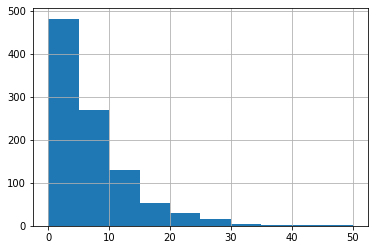

In [20]:
predictions_newest = pd.read_feather("predictions_on_best_friend_all_users_v4.feather")
precision_newest = precision_per_user(predictions_newest, df_test)
precision_newest.hist()

In [21]:
precision_newest.mean()

4.843117408906883

<AxesSubplot:>

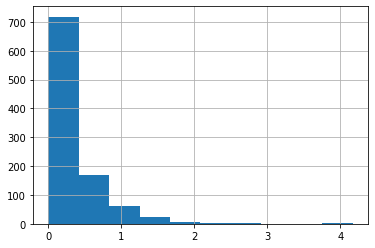

In [22]:
recall_newest = recall_per_user(predictions_newest, df_test)
recall_newest.hist()

In [23]:
recall_newest.mean()

0.30233265868561704

<AxesSubplot:>

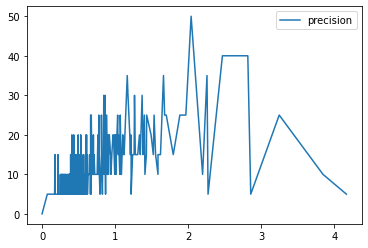

In [24]:
recall_precision_plot_newest = pd.concat([precision_newest, recall_newest], keys=["precision", "recall"], axis=1)
recall_precision_plot_newest = recall_precision_plot_newest.sort_values(["recall"])
recall_precision_plot_newest.plot.line(x="recall", y="precision", xlabel="")

<AxesSubplot:>

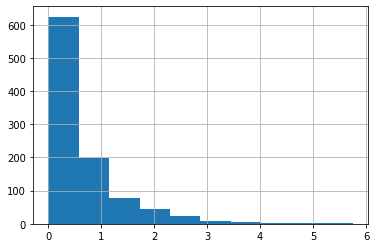

In [25]:
f1_newest = f1_per_user(predictions_newest, df_test)
f1_newest.hist()


In [26]:
f1_newest.mean()

0.5572760838050781

In [27]:
crt_newest = click_through_rate(users, 20, df_test, predictions_newest)
crt_newest

13.502024291497976

# Cold start problem

In [28]:
# Cold start popularity recommendation
user = "newUser" # This ID does not exist in the database
cold_start_predictions = db.predict_on_popularity(["newUser"])
cold_start_predictions


,userId,url
0,newUser,http://adressa.no/pluss/magasin/2017/01/14/fives-vei-til-banken-14051471.ece
1,newUser,http://adressa.no/pluss/magasin/2017/02/25/det-%c3%a5ret-vi-sluttet-%c3%a5-se-i-bakken-14308932.ece
2,newUser,http://adressa.no/pluss/magasin/2016/02/01/trondheim-f%c3%b8r-og-n%c3%a5-del-2-12100990.ece
3,newUser,http://adressa.no/bolig/boligguiden/trondheim/trondheim-%c3%b8st/bolig1196938.html
4,newUser,http://adressa.no/pluss/magasin/2017/01/14/fives-vei-til-banken-14051471.ece
5,newUser,http://adressa.no/nyheter/utenriks/2017/02/12/trump-skryter-av-aksjon-mot-ulovlige-innvandrere-14211432.ece
6,newUser,http://adressa.no/100sport/sprek/her-ligger-deltagerne-strodd-etter-treningsokten-studie-hevder-tre-minutter-i-uken-kan-vare-nok-228600b.html
7,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun-den-som-har-mistet-et-barn-selv-kan-vite-hvor-hjerteskj%c3%a6rende-det-er-14175719.ece
8,newUser,http://adressa.no/pluss/okonomi/2017/02/11/hun-lokker-nordmenn-til-%c3%a5-satse-store-penger-p%c3%a5-omstridt-nettvaluta-14205262.ece
9,newUser,http://adressa.no/pluss/magasin/2017/01/16/hvor-i-all-verden...-14066667.ece


In [29]:
# Cold start popularity recommendation with categories
categories = ["sport", "okonomi", "nyheter"] # Simulates a user inputs its preferred categories
user = "newUser" # This ID does not exist in the database
cold_start_categories_predictions = db.predict_on_popularity(["newUser"], categories)
cold_start_categories_predictions

,userId,url
0,newUser,http://adressa.no/nyheter/utenriks/2017/02/12/trump-skryter-av-aksjon-mot-ulovlige-innvandrere-14211432.ece
1,newUser,http://adressa.no/pluss/okonomi/2017/02/11/hun-lokker-nordmenn-til-%c3%a5-satse-store-penger-p%c3%a5-omstridt-nettvaluta-14205262.ece
2,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun-den-som-har-mistet-et-barn-selv-kan-vite-hvor-hjerteskj%c3%a6rende-det-er-14175719.ece
3,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun-den-som-har-mistet-et-barn-selv-kan-vite-hvor-hjerteskj%c3%a6rende-det-er-14175719.ece
4,newUser,http://adressa.no/nyheter/trondheim/2017/01/04/vurderer-%c3%a5-flytte-fra-midtbyen-14005344.ece
5,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun-den-som-har-mistet-et-barn-selv-kan-vite-hvor-hjerteskj%c3%a6rende-det-er-14175719.ece
6,newUser,http://adressa.no/nyheter/nordtrondelag/2017/01/29/n%c3%a5r-det-ufattelige-skjer-deg-14132649.ece
7,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun-den-som-har-mistet-et-barn-selv-kan-vite-hvor-hjerteskj%c3%a6rende-det-er-14175719.ece
8,newUser,http://adressa.no/nyheter/okonomi/2017/02/12/%c3%98lsalget-til-rema-stuper-med-ny-markedsstrategi-14210907.ece
9,newUser,http://adressa.no/pluss/nyheter/2017/02/27/de-unge-blir-fattigere-og-eldre-rikere-i-norge-14292336.ece
